import modules

In [2]:
# @title imports
from typing import Callable, List, Tuple
import sys
sys.path.insert(0, '../abc')
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import Image
from IPython import display
from tqdm import tqdm
import time
from abc_rej import abc_rej

# Finding $\beta$ for a set of observations using approximate Bayesian computation

## Summary statistics for the PCA

In order to perform ABC, we need to define a set of summary statistics $S(.)$ for the samples produced by the PCA model. Here, we have to make a few choices that will impact the performance of the ABC algorithms.

Our dataset $D = \{x_i, y_i\}_{i=1}^N$ consists of $N$ pairs of grid states. Each pair represents the transition of a grid from a state $x_i$ to a state $y_i$. The PCA model takes as input a grid state, simulates a time step for it, and returns the resulting state.

**1. Count the number of newly activated cells**

Our first summary statistic can be to simply count the number of cells transitioning from $x_{ij}^{(n)}= 0$ to $y_{ij}^{(n)}= 1$ for $n=1,\dots,N$ and sum up the result

**2. Collect the indices of the newly activated cells**

The second possible statistic is a collection of the indices of all cells that have changed state between $x_{ij}$ and $y_{ij}$. This allows e.g. to define the distance function as a pixel-wise loss function. 



In [9]:
# @title define summary statistics functions
def S1(X:t.Tensor, Y:t.Tensor) -> float:
  return t.sum((1-X)*Y, axis=(-1,-2))

def S2(X:t.Tensor, Y:t.Tensor) -> float:
  return (1-X)*Y

To test the functions, we can define a toy example transition:

$$
x_t = \begin{pmatrix}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0 
\end{pmatrix}, 
x_{t+1} = \begin{pmatrix}
0 & 1 & 0 \\
0 & 1 & 0 \\
0 & 1 & 1 
\end{pmatrix}
$$

## Distance functions

In order to perform ABC, we need to define a distance function $\rho(S(x_{sim}), S(x_{obs}))$ based on the summary statistics $S(.)$. 

**1. mean squared difference in newly activated cells**

**2. Sum of pixel-wise losses**

In [10]:
# @title define distance functions
def calc_distance_V1(X, Y_sim:np.ndarray, Y_obs:np.ndarray) -> float:
  # get statistics of the simulated set
  s_sim = S1(X, Y_sim)
  # get statistics of the observed set
  s_obs = S1(X, Y_obs)
  # calculate the mean difference
  return jnp.mean(jnp.square(s_sim - s_obs))

def calc_distance_V2(X, Y_sim:np.ndarray, Y_obs:np.ndarray) -> float:
  # get statistics of the simulated set
  s_sim = S1(X, Y_sim)
  # get statistics of the observed set
  s_obs = S1(X, Y_obs)
  # calculate the mean ratio
  return (1 - jnp.mean(s_sim / (s_obs+1)))**2

## Experiment 1: Generating a dataset from a single $\beta$ value

In [23]:
# @title set PCA parameters
grid_size = 9 #@param {type:"number"}
num_sequences = 100 #@param {type:"number"}
steps_per_sequence = 20 #@param {type: "number"}
beta = 0.08 #@param {type:"slider", min:0, max:1, step:0.01}

# @markdown ---
# @markdown parameters for the PCA visualization

frame_speed = 0.1 # @param {type:"slider", min:0.1, max:2, step:0.01}

In [ ]:
# @title visualize {vertical-output: true}
grids = init_grids(grid_size, 2)
for i in range(steps_per_sequence):
  visualize_batch(grids)
  display.display(plt.gcf())
  grids = model(grids, beta)
  display.clear_output(wait=True)
  time.sleep(frame_speed)

(1900, 2, 9, 9)


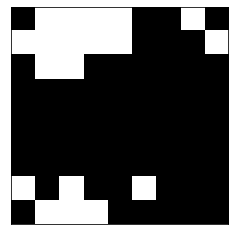

In [25]:
# @title generate dataset {vertical-output: true }
sequences = np.zeros((num_sequences, steps_per_sequence, grid_size, grid_size))
batch = init_grids(grid_size,num_sequences)

for i in range(steps_per_sequence):
  sequences[:,i,:,:] = batch
  batch = model(batch, beta)
np.save("./sequence_data", sequences)
visualize_sequence(sequences[np.random.randint(0,num_sequences)], framerate=0.1)
dataset = chop_and_shuffle_data(sequences)
np.save("./dataset", dataset)
print(dataset.shape)

In [ ]:
X = dataset[:,0]
Y_obs = dataset[:,1]
Y_sim = model(X, 0.8)
calc_distance_V1(X, Y_sim, Y_obs)

DeviceArray(304.85947, dtype=float32)

In [ ]:
X = dataset[:,0]
Y_obs = dataset[:,1]
Y_sim = model(X, 0.08)
calc_distance_V2(X, Y_sim, Y_obs)

DeviceArray(0.03147093, dtype=float32)

### Estimate $\beta$ via ABC-REJ

We define:

- $\epsilon = 0.1$ 
- $p(\theta) \sim U(0,1)$

In [ ]:
# @title define helpers
def sample_from_prior(size:int):
  return np.random.uniform(0,1,size)

In [ ]:
# @title define a rejection sampler function
def ABC_REJ(X:np.ndarray, Y_obs:np.ndarray, epsilon:float) -> float:
  num_steps = 1
  beta = None
  while True:
    beta = sample_from_prior(1)
    Y_sim = model(X, beta)
    distance = calc_distance_V2(X, Y_sim, Y_obs)
    if distance <= epsilon:
      break
    else:
      num_steps += 1
  return beta, num_steps

In [ ]:
# @title use ABC-REJ to draw approximate samples from the posterior  { vertical-output: true}
samples = []
required_steps = []
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilon = 0.1

# In the paper, 1,000 accepted samples are drawn
for i in tqdm(range(1000)):
  sample, num_steps = ABC_REJ(X, Y_obs, epsilon)
  samples.append(sample)
  required_steps.append(num_steps)

print(f"\n average # steps for acceptance: {np.mean(required_steps)}")




100%|██████████| 1000/1000 [10:21<00:00,  1.61it/s]

average # steps for acceptance: 14.296


Text(0, 0.5, 'density')

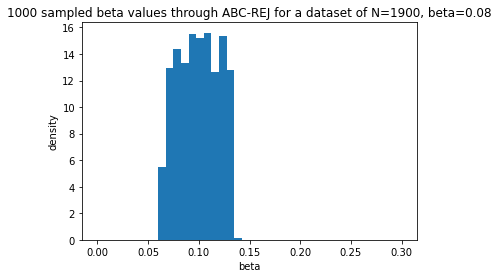

In [ ]:
# @title histogram of the samples {vertical-output: true}
n, bins, _ = plt.hist(np.array(samples).squeeze(-1), density=True, range=(0,0.3), bins=40)
plt.title("1000 sampled beta values through ABC-REJ for a dataset of N=1900, beta=0.08")
plt.xlabel("beta")
plt.ylabel("density")

### Estimate $\beta$ via ABC-MCMC

We define:

- $\epsilon = 0.1$ 
- $\beta_0 = 0.5$
- $q(\theta|\theta_t) \sim \mathcal{N}(\theta_t, 0.15^2)$


In [ ]:
# @title define helpers
def sample_from_prior(size:int):
  return np.random.uniform(0,1,size)

# @title Helper Functions
def gaussian_pdf(mu:float, sigma_sq:float) -> Callable:
  def pdf(x:float) -> float:
    return (1/(np.sqrt(2*np.pi)*np.sqrt(sigma_sq)))*np.exp(-(x-mu)**2/(2*sigma_sq))
  return pdf

def q(mu:float, sigma) -> float:
  return np.random.normal(mu, sigma)

def gauss_likelihood(x, y, sigma):
  """
  Calculate the likelihood of x as p(x|y) ~ N(y|sigma_sq)
  """
  pdf = gaussian_pdf(y, sigma)
  return pdf(x)

def uniform_likelihood(low:float, high:float, x:float) -> float:
  """
  Calculate the likelihood of x as p(x) ~ U(low, high)
  """
  if x > high or x < low:
    return 0 
  else:
    return 1 / (high-low)

def calc_alpha(beta_star:float, beta:float, epsilon:float, dist:float, sigma:float) -> float:
  if dist <= epsilon and uniform_likelihood(0, 1, beta_star) > 0:
    return min([1,gauss_likelihood(beta, beta_star, sigma)/gauss_likelihood(beta_star, beta, sigma)])
  else:
    return 0

In [ ]:
# @title Define ABC-MCMC
def ABC_MCMC(X:np.ndarray, Y_obs:np.ndarray, N:int, epsilon:float, beta:float, proposal_sigma:float) -> List[float]:
  betas = [beta]
  for i in tqdm(range(N)):
    beta_star = q(beta, proposal_sigma)
    Y_sim = model(X, beta_star)
    dist = calc_distance_V2(X, Y_sim, Y_obs)
    alpha = calc_alpha(beta_star, beta, epsilon, dist, proposal_sigma)
    if random.random() <= alpha:
      beta = beta_star
      betas.append(beta)
  return betas

100%|██████████| 10000/10000 [07:26<00:00, 22.42it/s]

accepted 1748 samples


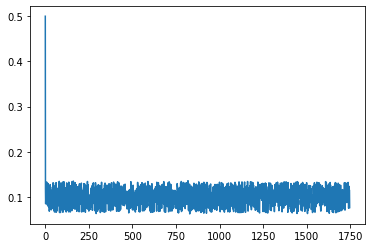

In [ ]:
# @title Run ABC-MCMC for the example { vertical-output: true}
N = 10000
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilon = 0.1
beta_init = 0.5
proposal_sigma = 0.15

betas = ABC_MCMC(X, Y_obs, N, epsilon, beta_init, proposal_sigma)

print(f"accepted {len(betas)} samples")

plt.plot(np.arange(len(betas)), betas)

Text(0, 0.5, 'density')

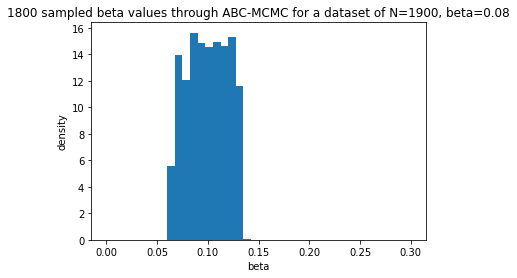

In [ ]:
# @title histogram of the samples {vertical-output: true}
n, bins, _ = plt.hist(betas, density=True, range=(0,0.3), bins=40)
plt.title("1800 sampled beta values through ABC-MCMC for a dataset of N=1900, beta=0.08")
plt.xlabel("beta")
plt.ylabel("density")

### Estimate $\beta$ via ABC-PRC

In [26]:
# @title define helper Functions
Sampler = Callable[[int], np.ndarray]

def mu_1(num_samples:int) -> float:
  return np.random.uniform(0, 1, num_samples)

def visualize_results(beta_hist:List[List[float]]) -> None:
  """
  Visualize the results of the ABC-PRJ algorithm.
  """
  fig, axs = plt.subplots(2,2, sharex=True, sharey=True)

  axs[0,0].hist(beta_hist[0], density=True, bins=30)
  axs[0,0].set(ylabel='density', title="Population 0")
  axs[0,1].hist(beta_hist[1], density=True, bins=30)
  axs[0,1].set(title="Population 1")
  axs[1,0].hist(beta_hist[2], density=True, bins=30)
  axs[1,0].set(xlabel='theta', ylabel='density', title="Population 2")
  axs[1,1].hist(beta_hist[3], density=True, bins=30)
  axs[1,1].set(xlabel='theta', title="Population 3")

  plt.xlim(0,1)
  plt.show()

In [27]:
# @title Define ABC-PRC
def ABC_PRC(N:int, epsilons:List[float], mu_1:Sampler, X, Y_obs) -> Tuple[List[float], List[List[float]]]:
  betas = mu_1(1000)
  beta_hist = [np.copy(betas)]
  for t, epsilon in enumerate(tqdm(epsilons)):
    for i in range(N):
      close_enough = False
      beta_star = beta_ss = x_ss = None
      while not close_enough:
        # Sample from previous population
        beta_star = np.random.choice(betas, size=1)
        # Move the particle with a gaussian markov kernel
        beta_ss = jnp.clip(np.random.normal(beta_star, 0.1), 0, 1)
        # sample Y_sim using beta**
        Y_sim = model(X, beta_ss)
        # check the distance
        close_enough = calc_distance_V2(X, Y_sim, Y_obs) <= epsilon
      betas[i] = beta_ss.copy()
    beta_hist.append(np.copy(betas))
  return betas, beta_hist

100%|██████████| 3/3 [02:35<00:00, 51.99s/it]


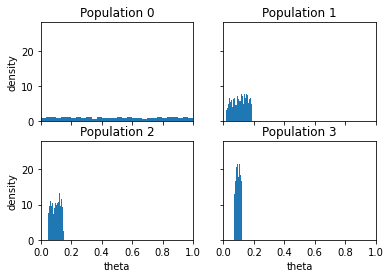

In [28]:
# @title Run ABC-PRC for the example { vertical-output: true}
N = 1000
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilons = [0.6, 0.2, 0.05]

betas, beta_hist = ABC_PRC(N, epsilons, mu_1, X, Y_obs)

visualize_results(beta_hist)

## Experiment 2: Generating a dataset from a distribution of $\beta$ values



In [11]:
# @title define helpers
def gaussian_pdf(mu:float, sigma_sq:float) -> Callable:
  def pdf(x:float) -> float:
    return (1/(np.sqrt(2*np.pi)*np.sqrt(sigma_sq)))*np.exp(-(x-mu)**2/(2*sigma_sq))
  return pdf

In [12]:
# @title set PCA parameters
grid_size = 30 #@param {type:"number"}
num_sequences = 100 #@param {type:"number"}
steps_per_sequence = 20 #@param {type: "number"}
# @markdown $\beta$ will be generated from a Gaussian distribution
# @markdown $\beta_t \sim\mathcal{N}(\mu, \sigma)$ and clipped to a range of $[0,1]$.
mu = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}
sigma = 0.1 #@param {type:"slider", min:0, max:1, step:0.01}

# @markdown ---
# @markdown parameters for the PCA visualization

frame_speed = 0.1 # @param {type:"slider", min:0.1, max:2, step:0.01}

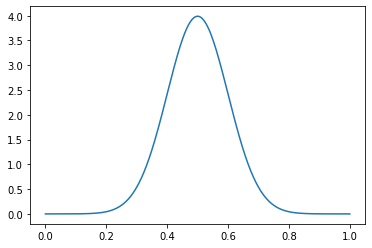

In [13]:
# @title visualize the distribution over $\beta$ {vertical-output: true }
beta_pdf = gaussian_pdf(mu, sigma**2)

x_vis = np.linspace(0,1,1_000)
y_vis = beta_pdf(x_vis)

plt.plot(x_vis, y_vis)

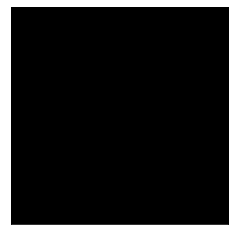

In [41]:
# @title visualize a sample sequence {vertical-output: true}
grid = init_grids(grid_size,1)
beta = jnp.clip(np.random.normal(mu,sigma), 0, 1)
sequence = [grid]
for i in range(steps_per_sequence):
  grid = model(grid, beta)
  sequence.append(grid.copy())
visualize_sequence(np.array(sequence).squeeze(), framerate=frame_speed)


for the experiment, we generate 1000 sequences. For each sequence, we draw a beta randomly from the 

In [14]:
sequences = np.zeros((num_sequences, steps_per_sequence, grid_size, grid_size))
betas = []

# @title generate dataset
for seq_idx in tqdm(range(num_sequences)):
  sequence = init_grids(grid_size,1)
  beta = jnp.clip(np.random.normal(mu, sigma), 0, 1)
  for step_idx in range(steps_per_sequence):
    sequences[seq_idx,step_idx,:,:] = sequence
    sequence = model(sequence, beta)
  betas.append(beta)

dataset = chop_and_shuffle_data(sequences)



100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


Text(0, 0.5, 'density')

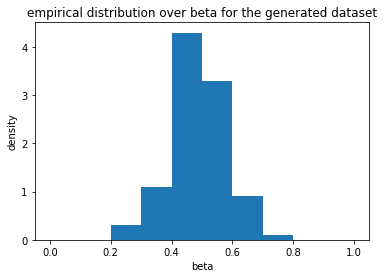

In [15]:
# @title visualize the empirical $\beta$ {vertical-output: true} distribution

n, bins, _ = plt.hist(betas, density=True, range=(0,1), bins=10)
plt.title("empirical distribution over beta for the generated dataset")
plt.xlabel("beta")
plt.ylabel("density")

In [16]:
# @title post-process the dataset to remove useless transitions (all active $\rightarrow$ all active)
print(dataset.shape)

mask = np.all(dataset[:,0] == 1, axis=(-1,-2))

num_faulty_entries = mask[mask==True].shape[0]

print(f"remove {num_faulty_entries} entries from the dataset")

dataset = np.delete(dataset, mask, axis=0)

dataset.shape

(1900, 2, 30, 30)
remove 33 entries from the dataset


(1867, 2, 30, 30)

### Estimate $\beta$ via ABC-REJ

We define:

- $\epsilon = 0.1$ 
- $p(\theta) \sim U(0,1)$

In [16]:
# @title define helpers
def sample_from_prior(size:int):
  return np.random.uniform(0,1,size)

In [17]:
# @title define a rejection sampler function
def ABC_REJ(X:np.ndarray, Y_obs:np.ndarray, epsilon:float) -> float:
  num_steps = 1
  beta = None
  dist_func_jit = jit(calc_distance_V2)
  while True:
    beta = sample_from_prior(1)
    Y_sim = model(X, beta)
    distance = dist_func_jit(X, Y_sim, Y_obs)
    if distance <= epsilon:
      break
    else:
      num_steps += 1
  return beta, num_steps

In [31]:
# @title use ABC-REJ to draw approximate samples from the posterior  { vertical-output: true}
samples = []
required_steps = []
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilon = 0.01

# In the paper, 1,000 accepted samples are drawn
for i in tqdm(range(1_000)):
  sample, num_steps = ABC_REJ(X, Y_obs, epsilon)
  samples.append(sample)
  required_steps.append(num_steps)

print(f"\n average # steps for acceptance: {np.mean(required_steps)}")




100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]


 average # steps for acceptance: 5.733


Text(0, 0.5, 'density')

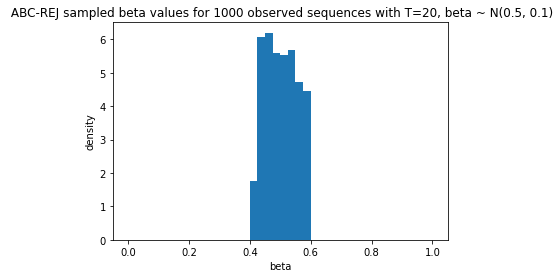

In [32]:
# @title histogram of the samples {vertical-output: true}
n, bins, _ = plt.hist(np.array(samples).squeeze(-1), density=True, range=(0,1), bins=40)
plt.title(f" ABC-REJ sampled beta values for 1000 observed sequences with T=20, beta ~ N({mu}, {sigma})")
plt.xlabel("beta")
plt.ylabel("density")

### Estimate $\beta$ via ABC-MCMC

In [45]:
# @title define helpers
def sample_from_prior(size:int):
  return np.random.uniform(0,1,size)

# @title Helper Functions
def gaussian_pdf(mu:float, sigma_sq:float) -> Callable:
  def pdf(x:float) -> float:
    return (1/(jnp.sqrt(2*jnp.pi)*jnp.sqrt(sigma_sq)))*jnp.exp(-(x-mu)**2/(2*sigma_sq))
  return pdf

def q(mu:float, sigma) -> float:
  return jnp.clip(np.random.normal(mu, sigma), 0, 1)

def gauss_likelihood(x, y, sigma):
  """
  Calculate the likelihood of x as p(x|y) ~ N(y|sigma_sq)
  """
  pdf = gaussian_pdf(y, sigma)
  return pdf(x)

def uniform_likelihood(low:float, high:float, x:float) -> float:
  """
  Calculate the likelihood of x as p(x) ~ U(low, high)
  """
  if x > high or x < low:
    return 0 
  else:
    return 1 / (high-low)

def calc_alpha(beta_star:float, beta:float, epsilon:float, dist:float, sigma:float) -> float:
  if dist <= epsilon and uniform_likelihood(0, 1, beta_star) > 0:
    return min([1,gauss_likelihood(beta, beta_star, sigma)/gauss_likelihood(beta_star, beta, sigma)])
  else:
    return 0

In [46]:
# @title Define ABC-MCMC
def ABC_MCMC(X:np.ndarray, Y_obs:np.ndarray, N:int, epsilon:float, beta:float, proposal_sigma:float) -> List[float]:
  betas = [beta]
  beta_hist = [beta]
  steps_per_sample = 1
  step_hist = []
  for i in tqdm(range(N)):
    beta_star = q(beta, proposal_sigma)
    Y_sim = model(X, beta_star)
    dist = calc_distance_V2(X, Y_sim, Y_obs)
    alpha = calc_alpha(beta_star, beta, epsilon, dist, proposal_sigma)
    if random.random() <= alpha:
      beta = beta_star
      betas.append(beta)
      step_hist.append(steps_per_sample)
      steps_per_sample = 1
    else:
      steps_per_sample += 1
    beta_hist.append(beta)
  return betas, beta_hist, step_hist

100%|██████████| 10000/10000 [10:46<00:00, 15.46it/s]


accepted 7998 samples


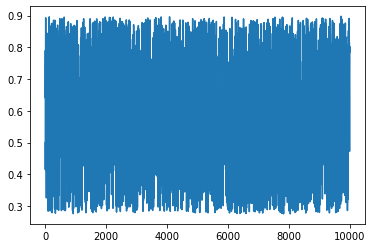

In [23]:
# @title Run ABC-MCMC for the example { vertical-output: true}
N = 10000
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilon = 0.1
beta_init = 0.5
proposal_sigma = 0.15

betas, beta_hist, step_hist = ABC_MCMC(X, Y_obs, N, epsilon, beta_init, proposal_sigma)

print(f"accepted {len(betas)} samples")

plt.plot(np.arange(len(beta_hist)), beta_hist)

Text(0, 0.5, 'density')

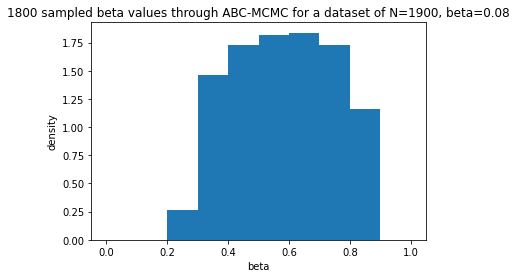

In [28]:
# @title histogram of the samples {vertical-output: true}
n, bins, _ = plt.hist(betas, density=True, range=(0,1), bins=10)
plt.title("1800 sampled beta values through ABC-MCMC for a dataset of N=1900, beta=0.08")
plt.xlabel("beta")
plt.ylabel("density")

### Estimate $\beta$ via ABC-PRC

we use:

- A population of $N=1000$ particles
- A sequence of three distributions $f_1, f_2, f_3$ defined through:
$$
f_t(\theta|\rho(S(x_{sim}), S(x_{obs})) \leq \epsilon_t) = \frac{\pi(\theta)}{B_t} \sum_{b=1}^{B_t} \textbf{1}(\rho(S(x_{(b)}), S(x_{obs})) \leq \epsilon_t)
$$
- $\epsilon_1=0.8, \epsilon_2=0.3, \epsilon_3=0.1$
- $\pi(\theta) \sim U(0,1)$
- $\mu_1(\theta)=\pi(\theta)$
- $K_t(\theta_t|\theta_{t-1})=L(\theta_{t-1}|\theta)$, gaussian random walks with $\theta_t \sim \mathcal{N}(\theta_{t-1}, 0.1)$

In [17]:
# @title define helper Functions
Sampler = Callable[[int], np.ndarray]

def mu_1(num_samples:int) -> float:
  return np.random.uniform(0, 1, num_samples)

def visualize_results(beta_hist:List[List[float]], mu, sigma) -> None:
  """
  Visualize the results of the ABC-PRJ algorithm.
  """
  beta_pdf = gaussian_pdf(mu, sigma**2)

  x_vis = np.linspace(0,1,1_000)
  y_vis = beta_pdf(x_vis)

  fig, axs = plt.subplots(2,2, sharex=True, sharey=True)

  axs[0,0].hist(beta_hist[0], density=True, bins=30)
  axs[0,0].plot(x_vis, y_vis)
  axs[0,0].set(ylabel='density', title="Population 0")
  axs[0,1].hist(beta_hist[1], density=True, bins=30)
  axs[0,1].plot(x_vis, y_vis)
  axs[0,1].set(title="Population 1")
  axs[1,0].hist(beta_hist[2], density=True, bins=30)
  axs[1,0].plot(x_vis, y_vis)
  axs[1,0].set(xlabel='theta', ylabel='density', title="Population 2")
  axs[1,1].hist(beta_hist[3], density=True, bins=30)
  axs[1,1].plot(x_vis, y_vis)
  axs[1,1].set(xlabel='theta', title="Population 3")

  plt.xlim(0,1)
  plt.show()

In [18]:
# @title Define ABC-PRC
def ABC_PRC(N:int, epsilons:List[float], mu_1:Sampler, X, Y_obs) -> Tuple[List[float], List[List[float]]]:
  betas = mu_1(1000)
  beta_hist = [np.copy(betas)]
  for t, epsilon in enumerate(tqdm(epsilons)):
    for i in range(N):
      close_enough = False
      beta_star = beta_ss = x_ss = None
      while not close_enough:
        # Sample from previous population
        beta_star = np.random.choice(betas, size=1)
        # Move the particle with a gaussian markov kernel
        beta_ss = jnp.clip(np.random.normal(beta_star, 0.1), 0, 1)
        # sample Y_sim using beta**
        Y_sim = model(X, beta_ss)
        # check the distance
        close_enough = calc_distance_V2(X, Y_sim, Y_obs) <= epsilon
      betas[i] = beta_ss.copy()
    beta_hist.append(np.copy(betas))
  return betas, beta_hist

100%|██████████| 3/3 [03:54<00:00, 78.04s/it]


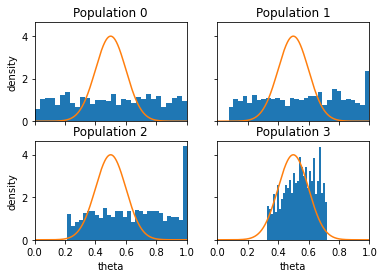

In [22]:
# @title Run ABC-PRC for the example { vertical-output: true}
N = 1000
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilons = [0.6, 0.2, 0.05]

betas, beta_hist = ABC_PRC(N, epsilons, mu_1, X, Y_obs)

visualize_results(beta_hist, mu, sigma)